In [1]:
import sys
def print_sys_info():
    print(sys.executable)
    print(sys.version)
    print(sys.version_info)

print_sys_info()

/Users/cuongduong/.local/share/virtualenvs/riiid-education-C7HMytLZ/bin/python
3.8.5 (default, Jul 21 2020, 10:48:26) 
[Clang 11.0.3 (clang-1103.0.32.62)]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [2]:
from datetime import datetime

import pandas as pd
import numpy as np
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt
import shap

plt.rcParams['figure.figsize'] = [8, 6]
sns.set_style('whitegrid')

In [3]:
TRAIN_SCHEMA = {
    'row_id': np.int64,
    'timestamp': np.int64,
    'user_id': np.int32,
    'content_id': np.int16,
    'content_type_id': np.int8,
    'task_container_id': np.int16,
    'user_answer': np.int8,
    'answered_correctly': np.int8,
    'prior_question_elapsed_time': np.float32,
    'prior_question_had_explanation': bool
}

In [56]:
DATAPREP_COLS = ['timestamp', 'user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time']
QUESTION_COLS = ['question_id', 'part', 'tags']

We'll read a subset of the training data only to make it faster to prototype and iterate. We can sample by users pretty easily because the csv file is already ordered by user and timestamp.

In [57]:
def read_train_sample(n_users: int, rows_per_read=200000):
    rows_read = 0
    user_count = 0
    dfs = []
    last_user_id = -1
    while user_count < n_users:
        df = pd.read_csv("train.csv", names=TRAIN_SCHEMA.keys(), usecols=DATAPREP_COLS, skiprows=rows_read+1, nrows=rows_per_read)
        first_user_id = df['user_id'].iloc[0]
        users_in_batch = df['user_id'].unique().shape[0]
        if last_user_id == first_user_id:
            users_in_batch -= 1
        user_count += users_in_batch
        last_user_id = df['user_id'].iloc[-1]
        rows_read += df.shape[0]
        if user_count >= n_users:
            df = df.loc[df['user_id'] != last_user_id]
        dfs.append(df)
    
    return pd.concat(dfs)

In [58]:
tr = read_train_sample(n_users=5000)

In [62]:
def read_questions():
    return pd.read_csv("questions.csv", usecols=QUESTION_COLS).rename(columns={'question_id': 'content_id'})

In [63]:
questions = read_questions()

We want to build separate features for question difficulty based on other users' answers, so we split the training dataset into two groups to prevent leaking answer information into the question difficulty features.

In [64]:
def split_train_data(df, question_features_perc=0.25):
    """
    - Exclude lecture observations
    - Randomly exclude a subset of users (content_model_sample_perc) for training content_id success rates (question difficulty)
    """
    df = df.loc[df['content_type_id'] == 0].drop(columns='content_type_id')
    users = df['user_id'].unique()
    np.random.shuffle(users)
    users_content_model = users[:int(question_features_perc * users.shape[0])]

    return {
        'user_model': df.loc[~df['user_id'].isin(users_content_model)].reset_index(drop=True),
        'question_features': df.loc[df['user_id'].isin(users_content_model)].reset_index(drop=True)
    }

In [65]:
splits = split_train_data(tr)

In [66]:
for k, df in splits.items():
    print(f"{k}: {df.shape[0]:,.0f} observations")

user_model: 1,063,586 observations
question_features: 305,586 observations


We will have the following content (i.e. question) features:

* Question level accuracy
* Question part accuracy (i.e. the overall accuracy in the part of the test the question comes from)

These will be calculated using a simple Beta-Binomial model with hardcoded priors. Specifically, we want at least 10 questions to be answered before the observed data starts overtaking the prior, and the prior should be set to `0.5` (we assume that the question is of medium difficulty if we haven't observed answers for it yet).

In [67]:
def explode_tags(questions_df):
    df = questions_df.copy()
    df['tags'] = questions_df['tags'].apply(lambda x: str(x).split(' '))
    df = df.explode('tags').rename(columns={'tags': 'tag'}).reset_index(drop=True)
    
    return df[['content_id', 'tag']]

In [87]:
def train_question_features(obs_df, questions_df):
    """
    Simple Beta-Binomial model for question difficulty at the question level and the question part level.
    """
    # Calculate accuracy at the question level
    obs_g = obs_df.groupby('content_id').agg({'content_id': 'count', 'answered_correctly': 'sum'}).rename(columns={'content_id': 'answered'}).reset_index()
    questions_df = pd.merge(questions_df, obs_g[['content_id', 'answered', 'answered_correctly']], how='left', on='content_id').fillna(0)
    # Calculate accuracy at the part level
    part_df = questions_df.groupby('part').agg({'answered': 'sum', 'answered_correctly': 'sum'}).reset_index()
    # Calculate accuracy at the tag level
    all_tags = explode_tags(questions_df)
    all_tags = pd.merge(all_tags, obs_g[['content_id', 'answered', 'answered_correctly']], how='left', on='content_id').fillna(0)
    tags_df = all_tags.groupby('tag').agg({'answered': 'sum', 'answered_correctly': 'sum'}).reset_index()
    
    prior_alpha = 10
    prior_beta = 10
    questions_df['question_accuracy'] = (questions_df['answered_correctly'] + prior_alpha) / (questions_df['answered'] + prior_alpha + prior_beta)
    part_df['part_accuracy'] = (part_df['answered_correctly'] + prior_alpha) / (part_df['answered'] + prior_alpha + prior_beta)
    tags_df['tag_accuracy'] = (tags_df['answered_correctly'] + prior_alpha) / (tags_df['answered'] + prior_alpha + prior_beta)
    
    questions_tags = pd.merge(all_tags[['content_id', 'tag']], tags_df[['tag', 'tag_accuracy']], on='tag')
    tags_summ = questions_tags.groupby('content_id').agg({'tag_accuracy': ['mean', 'count']}).reset_index()
    tags_summ.columns = ['content_id', 'avg_tag_accuracy', 'tag_count']
    
    features = pd.merge(questions_df, part_df[['part', 'part_accuracy']], on='part', how='left').fillna(-1)
    features = pd.merge(features, tags_summ, on='content_id', how='left').fillna(-1)
    
    return features

In [98]:
question_features = train_question_features(splits['question_features'], questions)

In [101]:
question_features

,content_id,part,tags,answered,answered_correctly,question_accuracy,part_accuracy,avg_tag_accuracy,tag_count
0,0,1,51 131 162 38,29.0,26.0,0.734694,0.726922,0.748210,4
1,1,1,131 36 81,22.0,20.0,0.714286,0.726922,0.752060,3
2,2,1,131 101 162 92,143.0,80.0,0.552147,0.726922,0.737154,4
3,3,1,131 149 162 29,75.0,55.0,0.684211,0.726922,0.756242,4
4,4,1,131 5 162 38,102.0,62.0,0.590164,0.726922,0.737033,4
...,...,...,...,...,...,...,...,...,...
13518,13518,5,14,4.0,3.0,0.541667,0.612169,0.691826,1
13519,13519,5,8,1.0,1.0,0.523810,0.612169,0.626224,1
13520,13520,5,73,4.0,3.0,0.541667,0.612169,0.589886,1
13521,13521,5,125,2.0,2.0,0.545455,0.612169,0.643843,1


#### Check the distribution of questions answered per user

If we want to create recency features, we can either do it based on time (i.e. the questions that the user answered within a certain timeframe before the current timestamp), or based on the last `n` questions answered. Doing it based on a time is a little complicated when working with DataFrames (would require an expensive join, or we would need to batch process the dataframe), so we'll do it based on the last `n` questions answered for the prototype.

Here we check the number of questions we have on hand for each user to help determine a cutoff for `n`. It won't tell us the "right" cutoff, but we mainly need to make sure that our `n` isn't too big that it covers most of the history for most users anyway.

In [102]:
dfs = splits['user_model'].groupby('user_id').agg({'content_id': 'count'}).rename(columns={'content_id': 'answered'})

In [103]:
pd.DataFrame({
    'q': np.arange(0, 1, 0.05),
    'value': np.quantile(dfs['answered'], q=np.arange(0, 1, 0.05))
})

,q,value
0,0.00,1.0
1,0.05,14.0
2,0.10,17.0
3,0.15,20.0
4,0.20,24.0
5,0.25,30.0
6,0.30,30.0
7,0.35,30.0
8,0.40,30.0
9,0.45,37.0


Here choosing `n = 10` seems fine, as most (>95%) of users have more than 5 questions answered in their history.

In [104]:
TRAIN_COLS = [
    'timestamp', 
    'user_id', 
    'answered', 
    'prior_question_elapsed_time', 
    'cum_accuracy', 
    'cum_accuracy_sd', 
    'recent_accuracy', 
    'recent_accuracy_sd', 
    'accuracy_trend', 
    'cum_avg_score',
    'recent_avg_score',
    'question_accuracy', 
    'part_accuracy',
    'avg_tag_accuracy',
    'tag_count',
    'frequency_of_use',
    'answered_correctly'
]

In [105]:
def cumsum_to_previous(x: pd.Series):
    """
    Cumulative sum to the previous value in the group, assuming the dataframe is sorted in ascending order of timestamp.
    """
    return x.shift(periods=1).cumsum()

def rollsum_to_previous(x: pd.Series, rolling_window: int):
    """
    Calculate rolling sum, assuming the dataframe is sorted in ascending order of timestamp.
    """
    return x.shift(periods=1).rolling(window=rolling_window).sum()

def cumsd_to_previous(x: pd.Series):
    """
    Calculate cumulative standard deviation, assuming the dataframe is sorted in ascending order of timestamp.
    """
    return x.shift(periods=1).expanding(min_periods=1).std()

In [111]:
def build_features(obs_df, question_features, recent_obs_number=100):
    obs_df = obs_df.copy()
    obs_df['prior_question_elapsed_time'] = obs_df['prior_question_elapsed_time'].fillna(-1)
    # Users' total previous accuracy
    user_g = obs_df.groupby('user_id')
    obs_df['answered'] = user_g.cumcount()
    obs_df['correct'] = user_g['answered_correctly'].apply(cumsum_to_previous).fillna(0)
    obs_df['cum_accuracy'] = (obs_df['correct'] / obs_df['answered']).fillna(-1)
    # Users' recent previous accuracy
    obs_df['answered_recent'] = obs_df['answered'].clip(upper=recent_obs_number)
    obs_df['correct_recent'] = user_g['answered_correctly'].apply(rollsum_to_previous, rolling_window=recent_obs_number)
    obs_df.loc[obs_df['correct_recent'].isna(), 'correct_recent'] = obs_df.loc[obs_df['correct_recent'].isna(), 'correct']
    obs_df['recent_accuracy'] = (obs_df['correct_recent'] / obs_df['answered_recent']).fillna(-1)
    # Stability in users' accuracy metric (i.e. how consistent is their track record)
    user_g = obs_df.groupby('user_id')
    obs_df['accuracy_trend'] = obs_df['recent_accuracy'] - obs_df['cum_accuracy']
    obs_df['cum_accuracy_sd'] = user_g['cum_accuracy'].apply(cumsd_to_previous).fillna(-1)
    obs_df['recent_accuracy_sd'] = user_g['recent_accuracy'].apply(cumsd_to_previous).fillna(-1)
    # Merge on question features
    obs_df = pd.merge(
        obs_df, 
        question_features[['content_id', 'question_accuracy', 'part_accuracy', 'avg_tag_accuracy', 'tag_count']],
        how='left',
        on='content_id',
    )
    # Users' previous performance taking into account the difficulty of the question. Score is between 0 and 2 (the higher the better)
    obs_df['answered_score'] = obs_df['answered_correctly'] - obs_df['question_accuracy'] + 1
    user_g = obs_df.groupby('user_id')
    obs_df['cum_score'] = user_g['answered_score'].apply(cumsum_to_previous).fillna(0)
    obs_df['cum_avg_score'] = (obs_df['cum_score'] / obs_df['answered']).fillna(-1)
    obs_df['recent_score'] = user_g['answered_score'].apply(rollsum_to_previous, rolling_window=recent_obs_number).fillna(0)
    obs_df['recent_avg_score'] = (obs_df['recent_score'] / obs_df['answered_recent']).fillna(-1)
    # User 'frequency of use' proxied by questions answered per day
    obs_df['frequency_of_use'] = ((obs_df['answered'] + 1) / (obs_df['timestamp'] / (1000 * 60 * 60 * 24))).replace([-np.inf, np.inf], np.nan).fillna(-1)
    
    return obs_df[TRAIN_COLS]

In [112]:
df = build_features(splits['user_model'], question_features)

In [113]:
df.head(n=20)

,timestamp,user_id,answered,prior_question_elapsed_time,cum_accuracy,cum_accuracy_sd,recent_accuracy,recent_accuracy_sd,accuracy_trend,cum_avg_score,recent_avg_score,question_accuracy,part_accuracy,avg_tag_accuracy,tag_count,frequency_of_use,answered_correctly
0,0,115,0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.0,0.712121,0.612169,0.489017,1,-1.000000,1
1,56943,115,1,37000.0,1.000000,-1.000000,1.000000,-1.000000,0.0,1.287879,0.0,0.804878,0.612169,0.689634,1,3034.613561,1
2,118363,115,2,55000.0,1.000000,1.414214,1.000000,1.414214,0.0,1.241500,0.0,0.878049,0.726922,0.765501,3,2189.873525,1
3,131167,115,3,19000.0,1.000000,1.154701,1.000000,1.154701,0.0,1.201651,0.0,0.813187,0.726922,0.741830,3,2634.809060,1
4,137965,115,4,11000.0,1.000000,1.000000,1.000000,1.000000,0.0,1.197941,0.0,0.860759,0.726922,0.765501,3,3131.228935,1
5,157063,115,5,5000.0,1.000000,0.894427,1.000000,0.894427,0.0,1.186201,0.0,0.870968,0.726922,0.744382,4,3300.586389,1
6,176092,115,6,17000.0,1.000000,0.816497,1.000000,0.816497,0.0,1.176673,0.0,0.857143,0.726922,0.776903,3,3434.568294,1
7,194190,115,7,17000.0,1.000000,0.755929,1.000000,0.755929,0.0,1.171842,0.0,0.782609,0.726922,0.753137,3,3559.400587,1
8,212463,115,8,16000.0,1.000000,0.707107,1.000000,0.707107,0.0,1.177536,0.0,0.821782,0.726922,0.735902,4,3659.931376,1
9,230983,115,9,16000.0,1.000000,0.666667,1.000000,0.666667,0.0,1.177612,0.0,0.851429,0.726922,0.764145,3,3740.535018,1


#### Check test set distribution

In order to prepare the validation dataset correctly we need to check how the test set is structured. Intuitively, we want to assess the accuracy of the model on all questions coming in, which means we observe all users for a set amount of time and evaluate against all questions attempted during that time. We haven't been given granular enough timestamp information to do that however, so depending on how we construct the validation set, the distribution of the observations we're evaluating on (in terms of users, user tenure) may be skewed.

We'll check the example test set for the spread of users (e.g. is it balanced, or are there more observations for power users, which would be the case if we were just predicting over a set timeframe) and the proportion of new users in the test dataset.

In [166]:
te = pd.read_csv("example_test.csv")

In [167]:
np.quantile(te.groupby(['group_num', 'user_id'])['row_id'].count().sort_values(ascending=False), q=np.arange(0, 1, 0.05))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       3., 3., 4.])

In [168]:
te.loc[te['user_id'] == 1310228392]

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
73,76,3,48613916248,1310228392,11869,0,1458,26333.0,True,NaN,NaN
74,77,3,48613916248,1310228392,11871,0,1458,26333.0,True,NaN,NaN
75,78,3,48613916248,1310228392,11870,0,1458,26333.0,True,NaN,NaN
76,79,3,48613916248,1310228392,11872,0,1458,26333.0,True,NaN,NaN
77,80,3,48613916248,1310228392,11868,0,1458,26333.0,True,NaN,NaN


In [169]:
test_user_count = te.groupby('user_id').agg({'row_id': 'count', 'timestamp': 'min'})

<AxesSubplot:xlabel='row_id', ylabel='Count'>

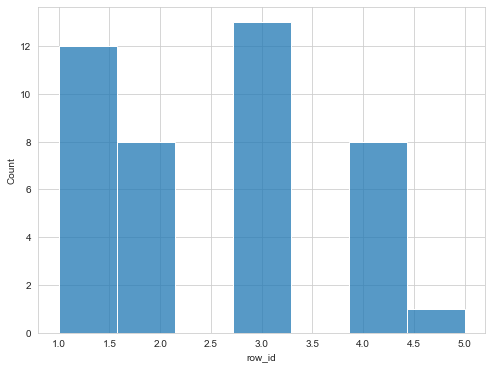

In [170]:
sns.histplot(test_user_count['row_id'])

In [171]:
test_user_count.loc[test_user_count['timestamp'] == 0]

,row_id,timestamp
user_id,,
275030867,4,0


In [172]:
te.shape

(104, 11)

* Only 42 users are in the example test set which has 104 rows, so it looks like we'll have to go on Kaggle to get an accurate estimate of the test set distribution
* One user is brand new (starting timestamp of 0) out of the 42, but again there's not enough data volume here to assume anything.

For the local validation we'll grab the last 10% of observations from each user, and set the percentage of new users in the validation set to 2%.

In [114]:
def prepare_validation_data(df, val_perc: float, perc_new_users: float):
    """
    val_perc: % user records to use as the validation dataset. These will be the last [val_perc] of observations for each user.
    perc_new_users: The percentage of users which we will treat as 'completely new'. The observations for these users will be in the validation set only
    """
    df = df.copy()
    user_g = df.groupby('user_id')
    summ = user_g.agg({'user_id': 'count'}).rename(columns={'user_id': 'total_questions'}).reset_index()
    df = pd.merge(df, summ, on='user_id')
    df['cum_perc_questions'] = df['answered'] / df['total_questions']
    
    new_users = summ.sample(frac=perc_new_users, random_state=123)
    df['in_val_df'] = (df['cum_perc_questions'] > 1 - val_perc) | (df['user_id'].isin(new_users['user_id']))
    
    return {
        'train': df.loc[~df['in_val_df']].drop(columns=['user_id', 'in_val_df', 'total_questions', 'cum_perc_questions']),
        'val': df.loc[df['in_val_df']].drop(columns=['user_id', 'in_val_df', 'total_questions', 'cum_perc_questions'])
    }

In [115]:
model_data = prepare_validation_data(df, val_perc=0.1, perc_new_users=0.02)

In [116]:
model_data['train'].shape

(940741, 16)

In [117]:
model_data['val'].shape

(122845, 16)

For the prototype model we won't do any hyper-parameter tuning. XGBoost is really good in this scenario because:

* Some of our predictors like `timestamp` and `answered` have long-tailed distributions that likely won't work well with a linear multiplicative assumption
* We can deal with missing values naturally (e.g. for the first question a user attempts, there is no historical data)

In [149]:
XGBOOST_PARAMS = {
    'n_estimators': 200,
    'max_depth': 8,
    'learning_rate': 0.05,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'hist',
    'subsample': 0.7,
    'missing': -1,
    'use_label_encoder': False,
}

In [150]:
def train_xgboost(model_data: dict, params: dict, target_col: str = 'answered_correctly'):
    m = xgboost.XGBClassifier(**params)
    X_train = model_data['train'].drop(columns=target_col)
    y_train = np.array(model_data['train'][target_col]).astype(int)
    X_val = model_data['val'].drop(columns=target_col)
    y_val =np.array(model_data['val'][target_col]).astype(int)
    
    tic = datetime.utcnow()
    m.fit(
        X=X_train,
        y=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=['logloss', 'auc'],
        verbose=False,
    )
    toc = datetime.utcnow()
    print(f"Model training time: {toc - tic}")
    
    return m

In [151]:
m = train_xgboost(model_data, XGBOOST_PARAMS)

Model training time: 0:00:46.801633


In [152]:
m.save_model("models/sample_1.b")

In [153]:
def extract_eval(model):
    dfs = []
    for name, data in model.evals_result().items():
        df = pd.DataFrame(data)
        df['iteration'] = [i + 1 for i in range(df.shape[0])]
        df['eval_set'] = name
        dfs.append(df)
    full_df = pd.concat(dfs)
    name_mapping = {'validation_0': 'train', 'validation_1': 'val'}
    full_df['eval_set'] = full_df['eval_set'].apply(lambda x: name_mapping.get(x))
    
    return full_df

In [154]:
eval_results = extract_eval(m)

Text(0.5, 1.0, 'AUC')

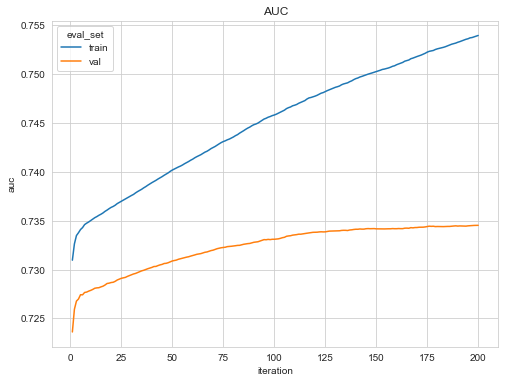

In [155]:
fig, ax = plt.subplots()
sns.lineplot(
    data=eval_results,
    x='iteration',
    y='auc',
    hue='eval_set',
)
plt.title('AUC')

Text(0.5, 1.0, 'Logistic Loss')

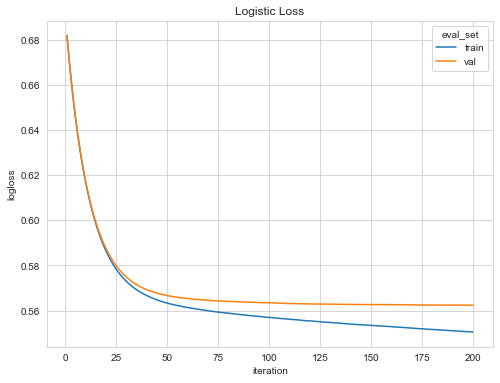

In [156]:
fig, ax = plt.subplots()
sns.lineplot(
    data=eval_results,
    x='iteration',
    y='logloss',
    hue='eval_set',
)
plt.title('Logistic Loss')

From the evaluation plots we can see that:

* The training AUC is not too far away from the test AUC in absolute terms, which is a good sign that the model isn't overfitting too much.
* That said, the test AUC is quite low. The existing leaderboards are showing top AUCs of around 0.8, so our prototype model seems to be far below the benchmark.
* Logloss flattens out much earlier than AUC. Our guess is that although we can capture most of the patterns on hand with the current set of features within the first 100 or so iterations, at that point there are still many predictions that are the same value (because the observations' values fall into the same tree path). By continuing to train, we are making the model more precise bit by bit (e.g. it might adjust predictions for the observations slightly up or slightly down), which helps with AUC but not logloss. This is fine as the test logloss remains flat while the test AUC improves.
* The test AUC stops improving after about 200 iterations, so for our actual model we should stop the training there.

Next we plot the feature importances, using both the "gain" metric built into the model, and the SHAP explainer.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

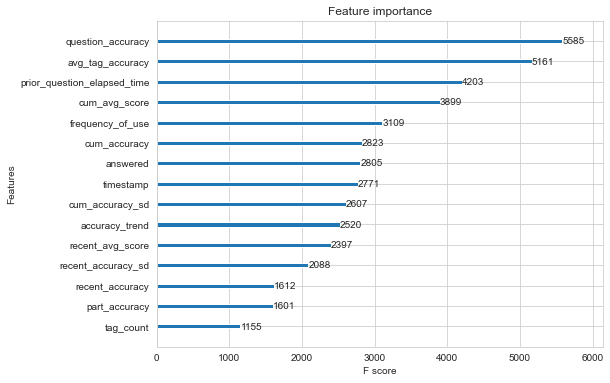

In [127]:
xgboost.plot_importance(m)

In [128]:
explainer = shap.TreeExplainer(m)

In [129]:
X = model_data['val'].drop(columns='answered_correctly').sample(n=5000)

In [130]:
shap_values = explainer.shap_values(X)

In [131]:
shap.initjs()

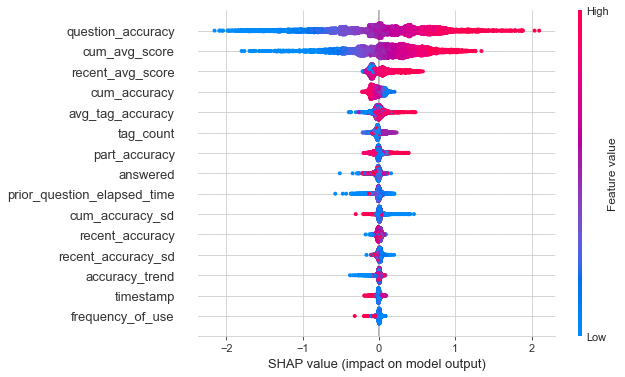

In [132]:
shap.summary_plot(shap_values, X, plot_size=(8, 6))

The ranking of feature importances does vary between the two measurement methods, but there are a couple of themes that stick out:

* The question accuracy feature has the most influence over the predictions. I'm guessing this is because when there is little to know about the user, these should have the highest weight (as a proxy for question difficulty), and it could be that a user has had a good streak with easier questions but this performance doesn't translate to harder questions. The question_part_accuracy embedding also contributes a decent amount, despite only having 7 distinct values. The highest priority features to work on would be the question features, and they'd also be easier to implement (we really just need a static lookup table with question embeddings for an MVP).
* cum_avg_score is a strong predictor, and is more influential than just a crude accuracy measure. Remember that this is comparing the user's performance on the question against the average performance on the question from other users.
* The accuracy SD is also a strong indicator interestingly enough. Users who have low standard deviation here are able to maintain their accuracy over time, while a high standard deviation means their accuracy dips up and down. The model is giving users with low standard deviation a higher probability of answering correctly, which makes intuitive sense.
* User tenure (number of questions answered), prior question elapsed time, and the frequency of use metric we defined don't seem to have a major impact on the model according to SHAP. They do appear in the top ranks by the "gain" metric interestingly enough. Nevertheless, this means we should include these metrics if they are easy to calculate on a rolling basis but shouldn't spend too much time trying to implement them perfectly.
* A disappointing result here is the poor performance of the `recent_accuracy` measures. Perhaps we need to rethink how we define our "recent" windows.


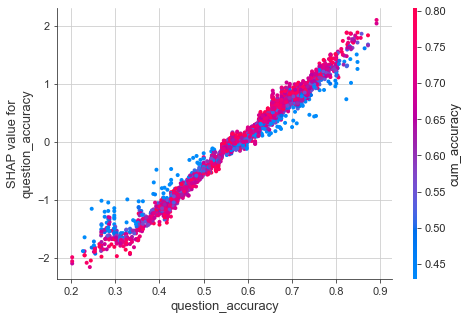

In [133]:
shap.dependence_plot("question_accuracy", shap_values, X)